In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import sklearn
from scipy.stats import zscore
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, f1_score, recall_score, make_scorer, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import scipy

from sklearn.svm import SVC 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

import matplotlib.pyplot as plt
from caveclient import CAVEclient
import seaborn as sn
import pandas as pd
from sklearn import preprocessing
import random
lb = preprocessing.LabelEncoder()

### Reading in the data 

In [33]:
merged_examples = pd.read_pickle('/Users/leilae/Documents/Mouse_connectomics/Soma_Nuc_paper/filtered_znorm_minnie_v661_94k_090823.pkl')
neuron_examples = merged_examples.query('neu_non_error_pred_soma ==1')
pss_histograms = pd.read_pickle('/Users/leilae/aibs/Neural_coding/data/Minnie_Full_PSS_histogram_surfaceareas.pkl')

minnie_column_df = neuron_examples.merge(pss_histograms, on='nucleus_id', how='inner')
minnie_column_df.shape, merged_examples.shape

((1302, 547), (94010, 61))

### Defining Metrics - Soma and Nucleus

In [34]:
metrics = ['nucleus_area_norm',
 'nucleus_area_to_volume_ratio_norm',
 'fold_area_nm_norm',
 'fract_fold_norm',
 'nucleus_to_soma_norm',
 'nucleus_volume_norm',
 'transformed_y_nm',
 'soma_volume_norm',
 'soma_area_norm',
 'soma_nuc_d_norm',
 'soma_area_to_volume_ratio_norm',
 'n_soma_syn_norm',
 'soma_syn_density_microns_norm']


In [4]:
minnie_column_df.cell_type_manual.value_counts()

23P         344
4P          263
6P-IT       184
6P-CT       140
5P-IT       137
BC           54
MC           40
5P-PT        37
BPC          33
6P-U         28
NGC          16
Unsure I     12
5P-NP        10
Unsure E      4
Name: cell_type_manual, dtype: int64

In [5]:
minnie_class =[] #cell_merged_minnie.cell_type.tolist()
for i in minnie_column_df.iterrows():
    i = i[1]
    if i.classification_system_manual == 'aibs_coarse_inhibitory': 
        minnie_class.append('inhibitory')
    elif i.classification_system_manual == 'aibs_coarse_excitatory':
        minnie_class.append('excitatory')
    elif i.classification_system_manual == 'aibs_coarse_nonneuronal':
        if i.cell_type == 'unsure' or i.cell_type == 'error':
            minnie_class.append(None)
        else:
            minnie_class.append(i.cell_type)
    else:
        minnie_class.append(None)
        

minnie_column_df['class_labels'] = minnie_class
minnie_column_df.class_labels.value_counts()

excitatory    1147
inhibitory     155
Name: class_labels, dtype: int64

### Model Functions

In [6]:
def train_model(data,labels, model, ordered_labels, cv=10):

#    train_model = model.fit(data, labels) 
#     scores = cross_validate(train_model, data, labels, 
#                              cv=5, scoring = ['accuracy','f1_macro', 'recall_macro', 'precision_macro'],
#                             return_estimator=True)
    y_pred = cross_val_predict(model, data, labels, cv=cv)
    conf_mat = confusion_matrix(labels, y_pred) 
    df_cm = pd.DataFrame(conf_mat, index = ordered_labels,
                      columns = ordered_labels)
    train_model = model.fit(data, labels)
    return train_model, y_pred, df_cm

def plot_cm(df_cm, save_fig=False, filename='', cmap="BuPu"):
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap=cmap,fmt='g')
    plt.xlabel('prediction')
    plt.ylabel('ground truth')
    if save_fig:
        plt.savefig(filename)

def test_model(model,test_data,test_labels, ordered_labels):
    final_pred = model.predict(test_data)

    test_accuracy = model.score(test_data, test_labels) 
    test_f1 = f1_score(test_labels, final_pred, average='weighted')
    test_recall = recall_score(test_labels, final_pred, average='weighted')
    test_precision = precision_score(test_labels,final_pred, average='weighted')
    #creating a confusion matrix 
    #cm_rbf = confusion_matrix(y_test, svm_rbf_predictions) 
    print('Test Accuracy: %.4f,Test Precision: %.4f, Test Recall: %.4f, Test F1 Score: %.4f'%(test_accuracy, test_precision, test_recall, test_f1))

    conf_mat = confusion_matrix(test_labels, final_pred) 

    df_cm = pd.DataFrame(conf_mat, index = ordered_labels,
                      columns = ordered_labels)
    return model, df_cm, final_pred


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

## Class Based Classifier
### (E/I/Oligo/Astro/Micro/OPC/Pericyte)

### Preparing the data

In [7]:

minnie_column_df.class_labels.value_counts()

excitatory    1147
inhibitory     155
Name: class_labels, dtype: int64

In [8]:

samples=minnie_column_df.query('class_labels =="excitatory" | class_labels=="inhibitory"')
samples.class_labels.value_counts()


excitatory    1147
inhibitory     155
Name: class_labels, dtype: int64

In [9]:
#Label_col should be altered depending on the classifier
label_col = 'class_labels'

numfiles = samples.shape[0]
all_idxs = np.arange(0, numfiles)
np.random.seed(49)
np.random.shuffle(all_idxs)
# percent_train = 80
# id_percent_train = int((percent_train/100) * numfiles) 
# train_idxs = all_idxs[:id_percent_train]
# test_idxs = all_idxs[id_percent_train:]

scaler=preprocessing.StandardScaler().fit(samples[metrics])
#balanced_scaled = scaler.transform(samples[metrics])
# train_df = balanced[metrics].iloc[train_idxs]
# train_dfs = scaler.transform(train_df)
# train_labels = balanced[label_col].iloc[train_idxs]
# val_df = balanced[metrics].iloc[test_idxs]
# val_dfs = scaler.transform(val_df)
# val_labels = balanced[label_col].iloc[test_idxs]

all_df = samples[metrics].iloc[all_idxs]
all_dfs = scaler.transform(all_df)
all_labels = samples[label_col].iloc[all_idxs]



In [10]:
# t =[]
# for i in range(samples.shape[0]):
#     if i in test_idxs:
#         t.append('test')
#     else:
#         t.append('train')
# samples['neuron_class_split'] = t

In [11]:
all_labels.value_counts()

excitatory    1147
inhibitory     155
Name: class_labels, dtype: int64

In [12]:
# Binarizing the labels
lb = preprocessing.LabelEncoder()
lb.fit_transform(samples[label_col])
uniq_labels=sorted(all_labels.unique())

bin_all_labels = lb.transform(all_labels)
# bin_train_labels = all_labels[train_idxs]
# bin_val_labels = all_labels[test_idxs]



### Hyperparameter Random Search Across Models

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


In [14]:
dataset_params = {
    'RBF SVM' : {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1),
                      'kernel': ['rbf'], 'class_weight':['balanced', None]},
    'Linear SVM' : {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1),
                      'kernel': ['linear'], 'class_weight':['balanced', None]},
    'Decision Tree': {'splitter':['best','random'], 'criterion':['gini', 'entropy'], 
                    'max_depth': scipy.stats.expon(scale=10),'min_samples_split': np.arange (0.01, 0.3, 0.02)},
    'Random Forest': {'n_estimators':np.arange(1,20), 'criterion':['gini', 'entropy'], 
                    'max_depth': scipy.stats.expon(scale=10),'min_samples_split':np.arange (0.01, 0.3, 0.02)},
    'Nearest Neighbors': {'n_neighbors':np.arange(5,100,20),'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'weights':['uniform','distance']},
    'Neural Net': {'hidden_layer_sizes':np.arange(10,150,10),'activation':['identity','tanh','relu','logistic'],
                  'solver':['sgd','adam'], 'alpha':scipy.stats.expon(scale=.1), 'learning_rate_init':scipy.stats.expon(scale=.1),
                  'learning_rate':['constant', 'invscaling','adaptive']}
    
}

In [82]:
for ds_cnt, ds in enumerate(classifiers):
    name = names[ds_cnt]
    if name in dataset_params.keys():
        n_iter_search = 100
        random_search = RandomizedSearchCV(ds, param_distributions=dataset_params[name], #refit = 'recall',
                                   n_iter=n_iter_search) #scoring = ['accuracy','f1', 'recall', 'precision'])
        
        start = time()
        random_search.fit(all_dfs, bin_all_labels)
        print(name)
        print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))
        report(random_search.cv_results_)

/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Nearest Neighbors
RandomizedSearchCV took 2.07 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.979 (std: 0.014)
Parameters: {'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'auto'}

Model with rank: 1
Mean validation score: 0.979 (std: 0.014)
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'auto'}

Model with rank: 1
Mean validation score: 0.979 (std: 0.014)
Parameters: {'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'ball_tree'}

Model with rank: 1
Mean validation score: 0.979 (std: 0.014)
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'ball_tree'}

Model with rank: 1
Mean validation score: 0.979 (std: 0.014)
Parameters: {'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'kd_tree'}

Model with rank: 1
Mean validation score: 0.979 (std: 0.014)
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'kd_tree'}

Model with rank: 1
Mean validation score: 0.979 (std: 0.014)
Parameters

KeyboardInterrupt: 

### SVM - RBF

CrossVal Accuracy: 0.9816,CrossVal Precision: 0.9819, CrossVal Recall: 0.9816, CrossVal F1 Score: 0.9809
Test Accuracy: 0.9823,Test Precision: 0.9827, Test Recall: 0.9823, Test F1 Score: 0.9817


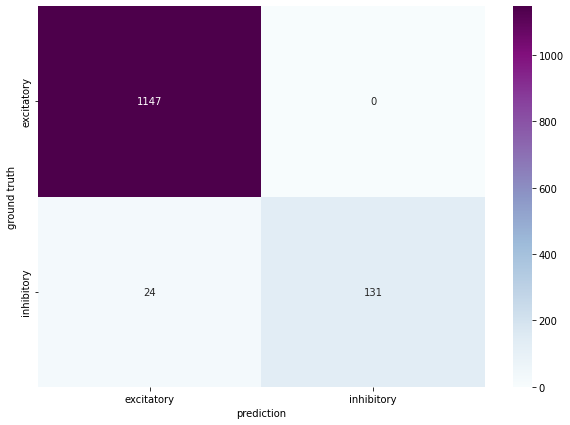

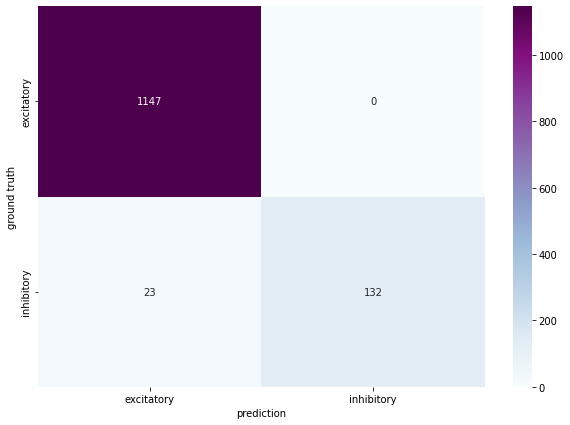

In [48]:
ordered_labels = sorted(samples[label_col].unique())

#first round
# #params = SVC(kernel = 'rbf', C = 1000,
#                     gamma= 0.01120242331473505,
#                     class_weight='balanced',
#                     decision_function_shape='ovo',
#                     probability=True)
params = {'C': 15.668401318176073, 'class_weight': None, 'gamma': 0.1420372322294404, 'kernel': 'rbf'}

svm_model_rbf = SVC(kernel = 'rbf', C = 200.668401318176073, #1.03 to lower overfitting
                    gamma= 0.0001420372322294404,
                    class_weight=None,
                    decision_function_shape='ovo',
                    probability=True)

rbf_model, cross_pred, rbf_cm = train_model(all_dfs,bin_all_labels, svm_model_rbf, ordered_labels)
cross_accuracy = accuracy_score(bin_all_labels, cross_pred)
cross_f1 = f1_score(bin_all_labels, cross_pred, average='weighted', zero_division=0)
cross_recall = recall_score(bin_all_labels, cross_pred, average='weighted', zero_division=0)
cross_precision = precision_score(bin_all_labels,cross_pred, average='weighted', zero_division=0)
print('CrossVal Accuracy: %.4f,CrossVal Precision: %.4f, CrossVal Recall: %.4f, CrossVal F1 Score: %.4f'%(cross_accuracy, cross_precision, cross_recall, cross_f1))

rbf_model, train_rbf_cm, train_pred  = test_model(rbf_model,all_dfs,bin_all_labels, ordered_labels)


train_file = '/Users/leilae/aibs/Neural_coding/Minnie/column_classifiers/figures/neuron_class_svm_rbf_train_soma.png'
test_file = '/Users/leilae/aibs/Neural_coding/Minnie/column_classifiers/figures/neuron_class_svm_rbf_TEST_soma.png'
plot_cm(rbf_cm, save_fig=False, filename=train_file)
plot_cm(train_rbf_cm, save_fig=False, filename=test_file)

### Using MLP Classifier!! 8/12

CrossVal Accuracy: 0.9846,CrossVal Precision: 0.9845, CrossVal Recall: 0.9846, CrossVal F1 Score: 0.9844
Test Accuracy: 0.9854,Test Precision: 0.9853, Test Recall: 0.9854, Test F1 Score: 0.9852


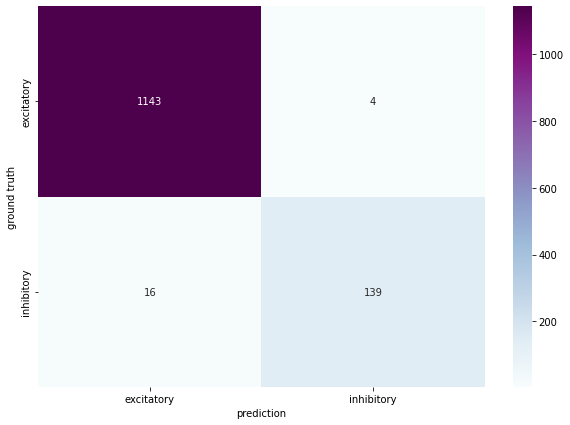

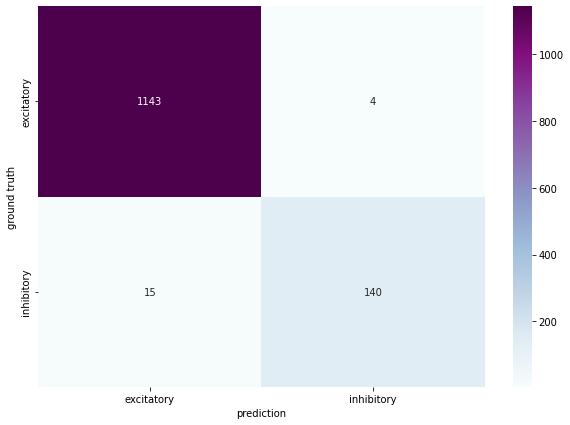

In [15]:
ordered_labels = sorted(samples[label_col].unique())

#first round
# #params = SVC(kernel = 'rbf', C = 1000,
#                     gamma= 0.01120242331473505,
#                     class_weight='balanced',
#                     decision_function_shape='ovo',
#                     probability=True)
params = {'activation': 'tanh', 'alpha': 0.02779055400477684, 'hidden_layer_sizes': 100,
          'learning_rate': 'constant', 'learning_rate_init': 0.020304839764349877, 'solver': 'adam'}

mlp_model_base = MLPClassifier(activation= 'tanh', 
                              alpha= 0.02779055400477684, 
                              hidden_layer_sizes= 100,
                              learning_rate= 'adaptive', 
                              learning_rate_init= 0.00020304839764349877, 
                              solver= 'adam',
                              max_iter=1000)

mlp_model, cross_pred, mlp_cm = train_model(all_dfs,bin_all_labels, mlp_model_base, ordered_labels)
cross_accuracy = accuracy_score(bin_all_labels, cross_pred)
cross_f1 = f1_score(bin_all_labels, cross_pred, average='weighted', zero_division=0)
cross_recall = recall_score(bin_all_labels, cross_pred, average='weighted', zero_division=0)
cross_precision = precision_score(bin_all_labels,cross_pred, average='weighted', zero_division=0)
print('CrossVal Accuracy: %.4f,CrossVal Precision: %.4f, CrossVal Recall: %.4f, CrossVal F1 Score: %.4f'%(cross_accuracy, cross_precision, cross_recall, cross_f1))

mlp_model, train_mlp_cm, train_pred  = test_model(mlp_model,all_dfs,bin_all_labels, ordered_labels)


train_file = '/Users/leilae/aibs/Neural_coding/Minnie/column_classifiers/figures/neuron_class_svm_rbf_train_soma.png'
test_file = '/Users/leilae/aibs/Neural_coding/Minnie/column_classifiers/figures/neuron_class_svm_rbf_TEST_soma.png'
plot_cm(mlp_cm, save_fig=False, filename=train_file)
plot_cm(train_mlp_cm, save_fig=False, filename=test_file)

In [16]:
import pickle
from joblib import dump, load

In [17]:
# with open('/Users/leilae/aibs/Neural_coding/models/rbf_svm_neuron_class_type_soma_model_080923.pkl','wb') as f:
#     pickle.dump(rbf_model,f)
    
with open('/Users/leilae/aibs/Neural_coding/models/mlp_neuron_class_type_soma_model_080923.pkl','wb') as f:
    pickle.dump(mlp_model,f)

In [18]:
import pickle
# filename = '/Users/leilae/aibs/Neural_coding/models/rbf_svm_neuron_class_type_soma_model_080923.pkl'
# model_soma = pickle.load(open(filename, 'rb'))


filename = '/Users/leilae/aibs/Neural_coding/models/mlp_neuron_class_type_soma_model_080923.pkl'
model_soma = pickle.load(open(filename, 'rb'))

In [19]:
merged_examples.columns

Index(['soma_id', 'soma_center_mass', 'soma_volume_nm', 'soma_area_nm',
       'soma_area_to_volume', 'n_soma_syn', 'soma_syn_density', 'frac_zero',
       'nucleus_id', 'is_watertight', 'nucleus_center_mass',
       'nucleus_avg_radius', 'nucleus_volume_nm', 'nucleus_area_nm',
       'nucleus_area_to_volume_ratio', 'nucleus_aspect_ratio',
       'nucleus_is_clipped', 'fold_area_nm', 'fract_fold', 'avg_fold_depth',
       'soma_nuc_d', 'nucleus_to_soma', 'classification_system_model',
       'cell_type_model', 'classification_system_manual', 'cell_type_manual',
       'frac_zeros', 'nuc_id', 'nucleus_area', 'nucleus_volume', 'soma_area',
       'soma_syn_density_microns', 'soma_volume', 'transformed_center_mass_nm',
       'transformed_x_nm', 'transformed_y_nm', 'transformed_z_nm',
       'nucleus_x_nm', 'nucleus_y_nm', 'nucleus_z_nm', 'umap_soma_zscore_x',
       'umap_soma_zscore_y', 'is_column', 'nucleus_volume_norm',
       'nucleus_area_norm', 'nucleus_area_to_volume_ratio_norm',


In [35]:
#column = minnie_column_df[~merged_examples[label_col].isna()]
all_scaled_col = scaler.transform(minnie_column_df[metrics])
all_scaled_minnie = scaler.transform(merged_examples[metrics])

preds_col = model_soma.predict(all_scaled_col)
preds_minnie = model_soma.predict(all_scaled_minnie)

merged_examples['neuron_class_pred_soma'] = preds_minnie
minnie_column_df['neuron_class_pred_soma'] = preds_col

In [36]:
update = []

for ix, i in merged_examples.iterrows():
    neuron = i.neu_non_error_pred_soma ==1
    c = i.neuron_class_pred_soma
    
    if neuron == True:
        update.append(int(c))
    else:
        update.append(None)
        
merged_examples['neuron_class_pred_soma'] = update

In [37]:
minnie_column_df.neuron_class_pred_soma.value_counts()

0    1158
1     144
Name: neuron_class_pred_soma, dtype: int64

In [38]:
merged_examples.query('neu_non_error_pred_soma==1').neuron_class_pred_soma.value_counts()

0.0    64193
1.0     7961
Name: neuron_class_pred_soma, dtype: int64

In [39]:
import seaborn as sns

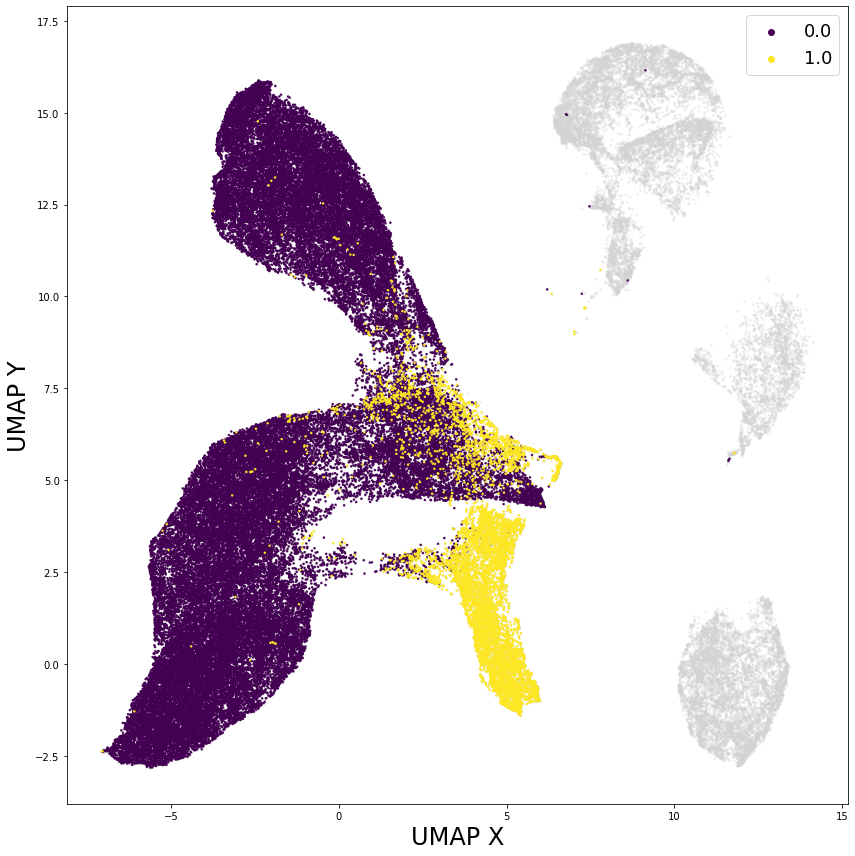

In [40]:
f, ax =plt.subplots(figsize=(12,12), facecolor='white')


sns.scatterplot( x='umap_soma_znorm_x', y='umap_soma_znorm_y', ax =ax, s=5, alpha=0.4, 
                edgecolor=None, data=merged_examples, legend = True, color= 'lightgray')

sns.scatterplot( x='umap_soma_znorm_x', y='umap_soma_znorm_y', ax =ax, s=5, alpha=1, hue='neuron_class_pred_soma',
                palette='viridis', legend = True,
                c=(.2,.2,.2),edgecolor=None, data= merged_examples.sort_values('neuron_class_pred_soma'))

# neu_errors = filtered_merged.query('neu_non_error_pred_soma==0 & umap_soma_znorm_x < 5')
# unlabeled = filtered_minnie[filtered_minnie.cell_type_model.isna()]
# sns.scatterplot( x='umap_soma_znorm_x', y='umap_soma_znorm_y', ax =ax, s=10, alpha=0.1, color='black',
#                 legend = True,edgecolor=None, data= unlabeled)


ax.set_xlabel('UMAP X', fontsize=24)
ax.set_ylabel('UMAP Y', fontsize=24)
f.tight_layout()
#plt.title('v117 Subclass Model Predictions onto Z Normalized Minnie v661', fontsize=24)
plt.legend(fontsize=18)
#plt.savefig('/Users/leilae/Documents/Mouse_connectomics/Soma_Nuc_paper/v661_neuron_class_preds_minnie_v661_96k_080823.png')
plt.show()

In [41]:
merged_examples.query('neuron_class_pred_soma ==1 & umap_soma_znorm_y>4 & umap_soma_znorm_x<5').shape #.soma_id.tolist()

(1440, 62)

In [42]:
inhib = pd.read_pickle('/Users/leilae/aibs/Neural_coding/data/minnie_w_errors_classified_060322.pkl')

inhib = inhib.query('soma_object_preds !=0 & soma_soma_merge==False & frac_zeros < 0.2 & cell_merged == True')
inhib = inhib.query('soma_neuron_class_preds == 1')
inhib.shape

(6544, 82)

In [43]:
merged_examples.query('neuron_class_pred_soma==1').soma_id.isin(inhib.seg_id.tolist()).value_counts()

False    5482
True     2479
Name: soma_id, dtype: int64

In [44]:
merged_examples['run_pss_v661'] = merged_examples.query('neuron_class_pred_soma==1').soma_id.isin(inhib.seg_id.tolist()) ==False
merged_examples.run_pss_v661.value_counts()

True     5482
False    2479
Name: run_pss_v661, dtype: int64

In [45]:
merged_examples.query('run_pss_v661 == True').neuron_class_pred_soma.value_counts()

1.0    5482
Name: neuron_class_pred_soma, dtype: int64

In [46]:
merged_examples.to_pickle('/Users/leilae/Documents/Mouse_connectomics/Soma_Nuc_paper/filtered_znorm_minnie_v661_94k_090823.pkl')

In [47]:
merged_examples.columns

Index(['soma_id', 'soma_center_mass', 'soma_volume_nm', 'soma_area_nm',
       'soma_area_to_volume', 'n_soma_syn', 'soma_syn_density', 'frac_zero',
       'nucleus_id', 'is_watertight', 'nucleus_center_mass',
       'nucleus_avg_radius', 'nucleus_volume_nm', 'nucleus_area_nm',
       'nucleus_area_to_volume_ratio', 'nucleus_aspect_ratio',
       'nucleus_is_clipped', 'fold_area_nm', 'fract_fold', 'avg_fold_depth',
       'soma_nuc_d', 'nucleus_to_soma', 'classification_system_model',
       'cell_type_model', 'classification_system_manual', 'cell_type_manual',
       'frac_zeros', 'nuc_id', 'nucleus_area', 'nucleus_volume', 'soma_area',
       'soma_syn_density_microns', 'soma_volume', 'transformed_center_mass_nm',
       'transformed_x_nm', 'transformed_y_nm', 'transformed_z_nm',
       'nucleus_x_nm', 'nucleus_y_nm', 'nucleus_z_nm', 'umap_soma_zscore_x',
       'umap_soma_zscore_y', 'is_column', 'nucleus_volume_norm',
       'nucleus_area_norm', 'nucleus_area_to_volume_ratio_norm',


In [67]:
merged_examples.neu_non_error_pred_soma.value_counts()

1    72154
2    21930
Name: neu_non_error_pred_soma, dtype: int64

In [170]:
import umap

In [171]:
tform=umap.UMAP(random_state=5)


M=merged_examples.query('neu_non_error_pred_soma==1')[metrics].fillna(0).values
print(M.shape)
Mz1=scipy.stats.zscore(M, axis=0)

Mt = tform.fit_transform(Mz1)

(72242, 13)


/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9100. The TBB threading layer is disabled.
  warnings.warn(problem)


In [172]:
filtered_minnie = merged_examples.query('neu_non_error_pred_soma==1')
filtered_minnie['class_umap_soma_znorm_x']=Mt[:,0]
filtered_minnie['class_umap_soma_znorm_y']=Mt[:,1]

/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
filtered_minnie.columns

Index(['soma_id', 'soma_center_mass', 'soma_volume_nm', 'soma_area_nm',
       'soma_area_to_volume', 'n_soma_syn', 'soma_syn_density', 'frac_zero',
       'nucleus_id', 'is_watertight', 'nucleus_center_mass',
       'nucleus_avg_radius', 'nucleus_volume_nm', 'nucleus_area_nm',
       'nucleus_area_to_volume_ratio', 'nucleus_aspect_ratio',
       'nucleus_is_clipped', 'fold_area_nm', 'fract_fold', 'avg_fold_depth',
       'soma_nuc_d', 'nucleus_to_soma', 'classification_system_model',
       'cell_type_model', 'classification_system_manual', 'cell_type_manual',
       'frac_zeros', 'nuc_id', 'nucleus_area', 'nucleus_volume', 'soma_area',
       'soma_syn_density_microns', 'soma_volume', 'transformed_center_mass_nm',
       'transformed_x_nm', 'transformed_y_nm', 'transformed_z_nm',
       'nucleus_x_nm', 'nucleus_y_nm', 'nucleus_z_nm', 'umap_soma_zscore_x',
       'umap_soma_zscore_y', 'is_column', 'nucleus_volume_norm',
       'nucleus_area_norm', 'nucleus_area_to_volume_ratio_norm',


<AxesSubplot:xlabel='soma_volume_norm', ylabel='nucleus_volume_norm'>

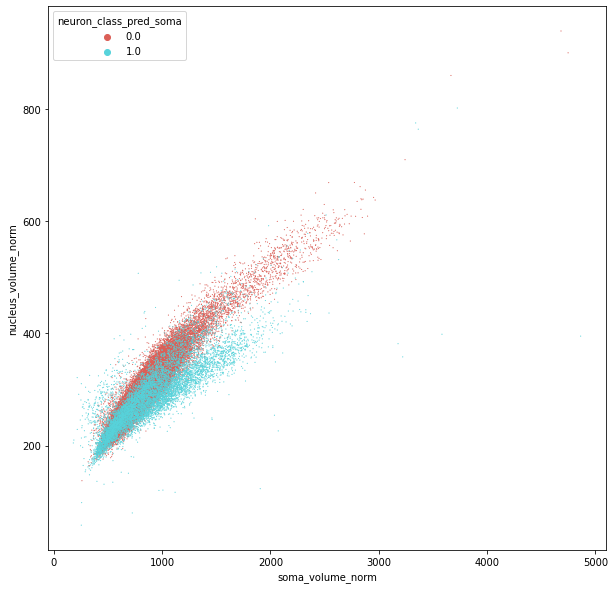

In [183]:
f, ax =plt.subplots(figsize=(10,10), facecolor='white')


sns.scatterplot( x='soma_volume_norm', y='nucleus_volume_norm', ax =ax, s=1, alpha=1, hue='neuron_class_pred_soma',
                palette='hls', legend = True,edgecolor=None, data= filtered_minnie.sort_values('neuron_class_pred_soma'))


In [185]:
filtered_minnie.query('soma_volume_norm > 1000 & neuron_class_pred_soma==1').soma_id.tolist()

[864691135367507449,
 864691135367507449,
 864691136841604580,
 864691135516630227,
 864691136288815255,
 864691135404021742,
 864691135909939625,
 864691135753674445,
 864691134940373347,
 864691137196892481,
 864691135428771632,
 864691136117069220,
 864691135182071554,
 864691135359161432,
 864691136089450807,
 864691135213077304,
 864691135117831645,
 864691136389095184,
 864691135696921754,
 864691135918346928,
 864691135777640893,
 864691135937398069,
 864691135927329236,
 864691135815900239,
 864691135437564658,
 864691136819432558,
 864691136578260756,
 864691135780793168,
 864691135953753096,
 864691135386380673,
 864691135658334594,
 864691135509651209,
 864691135725928255,
 864691135490826855,
 864691136024817977,
 864691135686890976,
 864691135919128496,
 864691135211116480,
 864691136698032238,
 864691135939643302,
 864691135940369062,
 864691136108738744,
 864691135738529905,
 864691135976150851,
 864691136100239477,
 864691136084428908,
 864691135468850514,
 864691135526

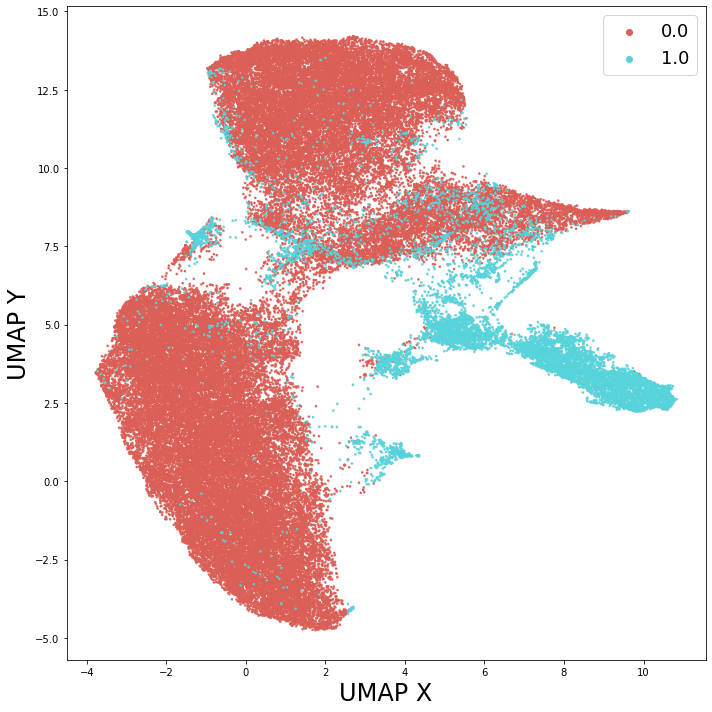

In [189]:
f, ax =plt.subplots(figsize=(10,10), facecolor='white')


sns.scatterplot( x='class_umap_soma_znorm_x', y='class_umap_soma_znorm_y', ax =ax, s=5, alpha=0.4, 
                edgecolor=None, data=filtered_minnie, legend = True, color= 'lightgray')

sns.scatterplot( x='class_umap_soma_znorm_x', y='class_umap_soma_znorm_y', ax =ax, s=5, alpha=1, hue='neuron_class_pred_soma',
                palette='hls', legend = True,edgecolor=None, data= filtered_minnie.sort_values('neuron_class_pred_soma'))

# neu_errors = filtered_merged.query('neu_non_error_pred_soma==0 & umap_soma_znorm_x < 5')
# unlabeled = filtered_minnie[filtered_minnie.cell_type_model.isna()]
# sns.scatterplot( x='umap_soma_znorm_x', y='umap_soma_znorm_y', ax =ax, s=10, alpha=0.1, color='black',
#                 legend = True,edgecolor=None, data= unlabeled)


ax.set_xlabel('UMAP X', fontsize=24)
ax.set_ylabel('UMAP Y', fontsize=24)
f.tight_layout()
#plt.title('v117 Subclass Model Predictions onto Z Normalized Minnie v661', fontsize=24)
plt.legend(fontsize=18)
#plt.savefig('/Users/leilae/Documents/Mouse_connectomics/Soma_Nuc_paper/v661_neuron_class_preds_minnie_v661_96k_080823.png')
plt.show()

In [178]:
filtered_minnie.query('class_umap_soma_znorm_y<2.5 & class_umap_soma_znorm_x>3 & neuron_class_pred_soma==1').shape

(718, 64)

In [191]:
filtered_minnie.neuron_class_pred_soma.value_counts()

0.0    62934
1.0     9308
Name: neuron_class_pred_soma, dtype: int64

In [93]:
minnie_column_df.to_pickle('/Users/leilae/aibs/Neural_coding/data/minnie_column_with_preds_0307.pkl')
merged_examples.to_pickle('/Users/leilae/aibs/Neural_coding/data/minnie_val_with_preds_no_errors_0307.pkl')

In [28]:
min_val = pd.read_pickle('/Users/leilae/aibs/Neural_coding/data/minnie_val_all_classifiers_0110.pkl')

In [33]:
gt_labels_col = lb.transform(column[label_col])

In [35]:
conf_mat = confusion_matrix(gt_labels_col, column.class_based_pred_soma) 

df_cm_col = pd.DataFrame(conf_mat, index = ordered_labels,
                      columns = ordered_labels)
df_cm_col

,OPC,astrocyte,excitatory,inhibitory,microglia,oligo,pericyte
OPC,26,0,0,1,0,1,0
astrocyte,0,148,0,1,0,1,0
excitatory,0,0,1194,0,0,0,0
inhibitory,0,0,9,154,0,0,0
microglia,1,0,0,0,58,0,1
oligo,0,0,1,0,2,114,0
pericyte,1,0,0,0,2,0,167


In [36]:
ordered_labels

['OPC',
 'astrocyte',
 'excitatory',
 'inhibitory',
 'microglia',
 'oligo',
 'pericyte']

In [38]:
pred_label = []
for i in minnie_val.class_based_pred_soma:
    pred_label.append(ordered_labels[i])
    
minnie_val['class_based_pred_soma_label'] = pred_label

In [39]:
minnie_val['class_based_pred_soma_label'].value_counts()

excitatory    58260
inhibitory     7568
astrocyte      7532
oligo          5556
pericyte       2565
microglia      1821
OPC            1225
Name: class_based_pred_soma_label, dtype: int64

### Applied to Basil 

In [67]:
import pickle
basil = pd.read_pickle('/Users/leilae/aibs/Neural_coding/data/basil_features_W_embedding_011822.pkl')
minnie_val =pd.read_pickle('/Users/leilae/aibs/Neural_coding/data/minnie_val_all_classifiers_no_errors_0124.pkl')
filename = '/Users/leilae/aibs/Neural_coding/models/rbf_svm_class_type_soma_model_0111.pkl'
model_soma = pickle.load(open(filename, 'rb'))

In [68]:
means_column=np.mean(samples[metrics], axis=0)
stds_column=np.std(samples[metrics], axis=0)

In [69]:
minnie_val.class_based_pred_soma.value_counts()

2    58260
3     7568
1     7532
5     5556
6     2565
4     1821
0     1225
Name: class_based_pred_soma, dtype: int64

In [70]:
metrics_basil = ['soma_synapses', 'soma_area', 'soma_area_to_volume',
       'soma_syn_density', 'soma_volume', 'depth', 
       'nucleus_area_largest', 'nucleus_area_to_volume_largest',
       'nucleus_fold_area_largest', 'nucleus_fract_fold_largest',
       'nucleus_volume_largest','nucleus_to_soma_largest']

all_scaled_col = scaler.fit(merged_examples[metrics])
all_scaled_minnie = scaler.transform(minnie_val[metrics])
all_scaled_basil = scaler.transform(basil[metrics_basil])


In [71]:
preds_basil = model_soma.predict(all_scaled_basil)
preds_minnie = model_soma.predict(all_scaled_minnie)

In [72]:
minnie_val['class_based_pred_soma_v1'] = preds_minnie
basil['class_based_pred_soma'] = preds_basil

In [73]:
minnie_val.class_based_pred_soma_v1.value_counts()

2    59895
1     7689
3     6156
5     5965
0     4398
4      227
6      197
Name: class_based_pred_soma_v1, dtype: int64

In [74]:
basil_sure.class_based_pred_soma.value_counts()

2    1552
3     140
0      92
1      83
5      75
4       2
Name: class_based_pred_soma, dtype: int64

In [75]:
basil_sure = basil.query('Tags_both !="unsure"')
labels = []
for i in basil_sure.Tags_both:
    if i =='excitatory':
        labels.append(2)
    elif i == 'inhibitory':
        labels.append(3)
    elif i == 'opc':
        labels.append(0)
    elif i == 'astrocyte':
        labels.append(1)
    elif i == 'microglia':
        labels.append(4)
    elif i == 'oligo':
        labels.append(5)

basil_sure['class_type_labels'] = labels

In [76]:
ordered_labels = ['opc', 'astrocyte', 'excitatory', 'inhibitory', 'microglia', 'oligo']


conf_mat = confusion_matrix(basil_sure.class_type_labels, basil_sure.class_based_pred_soma) 

df_cm_col = pd.DataFrame(conf_mat, index = ordered_labels,
                      columns = ordered_labels)
df_cm_col

,opc,astrocyte,excitatory,inhibitory,microglia,oligo
opc,34,2,1,0,0,0
astrocyte,1,81,1,0,0,0
excitatory,0,0,1505,7,0,0
inhibitory,1,0,45,133,0,0
microglia,56,0,0,0,2,12
oligo,0,0,0,0,0,63


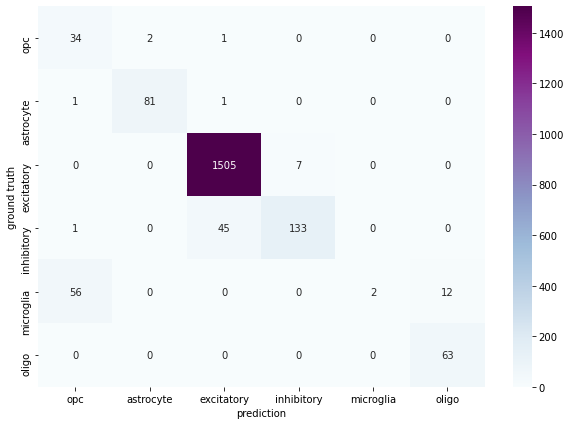

In [42]:
val_file = '/Users/leilae/aibs/Neural_coding/Minnie/column_classifiers/figures/class_type_svm_rbf_BASIL_soma.png'
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_col, annot=True, cmap="BuPu",fmt='g')
plt.xlabel('prediction')
plt.ylabel('ground truth')
#plt.savefig(val_file)

In [39]:
basil.to_pickle('/Users/leilae/aibs/Neural_coding/data/basil_features_W_embedding_011822.pkl')

## Classifier Validation

In [40]:
import os
import dash
import pandas as pd
from dashdataframe import configure_app
from nglui.statebuilder import *

In [41]:
client = CAVEclient()
datastack_name = 'minnie65_phase3_v1'

client = CAVEclient(datastack_name)


### Predicted Excitatory Neurons

In [42]:
img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='minnie_imagery',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()
seg_layer = SegmentationLayerConfig(name = 'minnie_seg',
                                    source = seg_source,
                                   selected_ids_column = 'pt_root_id')
nuc_seg_source = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'minnie_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='pt_position', linked_segmentation_column = 'pt_root_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='pt_position', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,nuc_seg_layer, anno_layer,nuc_anno_layer], resolution=[4,4,40])


df = minnie_val.query('class_based_pred_soma_label == "excitatory"')
df = df[~df.pt_root_id.isna()].sample(200, random_state=42).reset_index()
sb.render_state(df, return_as='html')

### Predicted Inhibitory Neurons

In [43]:
img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='minnie_imagery',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()
seg_layer = SegmentationLayerConfig(name = 'minnie_seg',
                                    source = seg_source,
                                   selected_ids_column = 'pt_root_id')
nuc_seg_source = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'minnie_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='pt_position', linked_segmentation_column = 'pt_root_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='pt_position', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,nuc_seg_layer, anno_layer,nuc_anno_layer], resolution=[4,4,40])


df = minnie_val.query('class_based_pred_soma_label == "inhibitory"')
df = df[~df.pt_root_id.isna()].sample(200, random_state=42).reset_index()
sb.render_state(df, return_as='html')

### Predicted Astrocyte

In [44]:
img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='minnie_imagery',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()
seg_layer = SegmentationLayerConfig(name = 'minnie_seg',
                                    source = seg_source,
                                   selected_ids_column = 'pt_root_id')
nuc_seg_source = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'minnie_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='pt_position', linked_segmentation_column = 'pt_root_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='pt_position', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,nuc_seg_layer, anno_layer,nuc_anno_layer], resolution=[4,4,40])


df = minnie_val.query('class_based_pred_soma_label == "astrocyte"')
df = df[~df.pt_root_id.isna()].sample(200, random_state=42).reset_index()
sb.render_state(df, return_as='html')

### Predicted Oligo

In [46]:
img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='minnie_imagery',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()
seg_layer = SegmentationLayerConfig(name = 'minnie_seg',
                                    source = seg_source,
                                   selected_ids_column = 'pt_root_id')
nuc_seg_source = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'minnie_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='pt_position', linked_segmentation_column = 'pt_root_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='pt_position', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,nuc_seg_layer, anno_layer,nuc_anno_layer], resolution=[4,4,40])


df = minnie_val.query('class_based_pred_soma_label == "oligo"')
df = df[~df.pt_root_id.isna()].sample(200, random_state=42).reset_index()
sb.render_state(df, return_as='html')

### Predicted Microglia

In [47]:
img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='minnie_imagery',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()
seg_layer = SegmentationLayerConfig(name = 'minnie_seg',
                                    source = seg_source,
                                   selected_ids_column = 'pt_root_id')
nuc_seg_source = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'minnie_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='pt_position', linked_segmentation_column = 'pt_root_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='pt_position', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,nuc_seg_layer, anno_layer,nuc_anno_layer], resolution=[4,4,40])


df = minnie_val.query('class_based_pred_soma_label == "microglia"')
df = df[~df.pt_root_id.isna()].sample(200, random_state=42).reset_index()
sb.render_state(df, return_as='html')

### Predicted OPC

In [48]:
img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='minnie_imagery',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()
seg_layer = SegmentationLayerConfig(name = 'minnie_seg',
                                    source = seg_source,
                                   selected_ids_column = 'pt_root_id')
nuc_seg_source = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'minnie_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='pt_position', linked_segmentation_column = 'pt_root_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='pt_position', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,nuc_seg_layer, anno_layer,nuc_anno_layer], resolution=[4,4,40])


df = minnie_val.query('class_based_pred_soma_label == "OPC"')
df = df[~df.pt_root_id.isna()].sample(200, random_state=42).reset_index()
sb.render_state(df, return_as='html')

### Predicted Pericyte

In [49]:
img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='minnie_imagery',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()
seg_layer = SegmentationLayerConfig(name = 'minnie_seg',
                                    source = seg_source,
                                   selected_ids_column = 'pt_root_id')
nuc_seg_source = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-ws/nuclei/v0/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'minnie_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='pt_position', linked_segmentation_column = 'pt_root_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='pt_position', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,nuc_seg_layer, anno_layer,nuc_anno_layer], resolution=[4,4,40])


df = minnie_val.query('class_based_pred_soma_label == "pericyte"')
df = df[~df.pt_root_id.isna()].sample(200, random_state=42).reset_index()
sb.render_state(df, return_as='html')

### Basil Validation

In [41]:
img_source = "precomputed://https://storage.googleapis.com/neuroglancer/basil_v0/son_of_alignment/v3.04_cracks_only_normalized_rechunked"
img_layer = ImageLayerConfig(name='basil_imagery',
                             source=img_source)
seg_source = "precomputed://https://storage.googleapis.com/neuroglancer/basil_v0/basil_full/seg-aug"
seg_layer = SegmentationLayerConfig(name = 'basil_seg',
                                    source = seg_source)

nuc_seg_source = 'precomputed://gs://neuroglancer/basil_v0/basil_full/nucleus/3d_v1/seg'

nuc_seg_layer = SegmentationLayerConfig(name = 'basil_nuc_seg',
                                    source = nuc_seg_source,
                                   selected_ids_column = 'nucleus_id')

points = PointMapper(point_column='center_ng', linked_segmentation_column = 'soma_id')
anno_layer = AnnotationLayerConfig(name='soma_annos',
                                   mapping_rules=points )

nuc_points = PointMapper(point_column='center_ng', linked_segmentation_column = 'nucleus_id')
nuc_anno_layer = AnnotationLayerConfig(name='nuc_annos',
                                   mapping_rules=nuc_points )

sb = StateBuilder([img_layer, seg_layer,anno_layer,nuc_seg_layer, nuc_anno_layer], resolution=[4,4,40])


df = basil_sure.query('class_based_pred_soma == 2 & class_type_labels==3')
df = df[~df.soma_id.isna()]#.sample(200, random_state=42).reset_index()
df
sb.render_state(df, return_as='html')

In [45]:
minnie_nuc_all.query('new_pred == 0 & predict ==0').shape

NameError: name 'minnie_nuc_all' is not defined

In [426]:
minnie_nuc_all.query('new_pred == 0 & predict ==0').sample(100, random_state=42).reset_index()

,index,nucleus_area,nucleus_area_to_volume,nucleus_center_mass_nm,nucleus_fold_area,nucleus_fract_fold,nucleus_id,nucleus_volume,cleft_segid,size,centroid_x,centroid_y,centroid_z,yr_um_translated,predict,new_pred,id,pt_root_id,pt_position
0,106802,12.774397,2.519749,"[95.15878603493033, 93.28403774937685, 29.2621...",0.738166,0.057785,378634,1.073368,378634.0,6698.0,14132.0,16100.0,20492.0,685.306854,0,0,NaN,<NA>,NaN
1,150837,65.655392,3.500522,"[157.51541749842812, -109.05536241230827, 30.7...",5.937099,0.090428,729431,7.638010,729431.0,47616.0,24102.0,16831.0,17276.0,787.525163,0,0,NaN,<NA>,NaN
2,9967,6.077979,2.891990,"[6.418542345391415, -19.954450190860356, 20.53...",0.000000,0.000000,603811,0.286495,603811.0,1779.0,21490.0,4561.0,21635.0,-9.336261,0,0,NaN,<NA>,NaN
3,37518,175.442146,2.446018,"[-155.54827689154865, 35.20990187439528, 108.3...",4.102315,0.023383,619921,57.119601,619921.0,349151.0,21840.0,12618.0,22493.0,506.301832,0,0,619921.0,864691135918888344,"[349440, 201888, 22493]"
4,141878,34.823221,1.514587,"[55.75640142760982, 25.824064179255192, -57.61...",0.198499,0.005700,213762,10.366594,213762.0,63684.0,8330.0,18199.0,25403.0,786.768297,0,0,NaN,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,135614,225.734055,2.566167,"[14.274814502588208, 100.14355274435555, 39.62...",20.561909,0.091089,756366,77.578641,756366.0,473863.0,24715.0,10034.0,23216.0,357.591794,0,0,756366.0,864691135061548064,"[395440, 160544, 23216]"
96,68456,33.147435,3.029793,"[124.48463793877747, -68.51987169504845, 111.5...",8.648902,0.260922,669439,3.402744,669439.0,21215.0,23377.0,12349.0,21132.0,497.724680,0,0,NaN,<NA>,NaN
97,140374,28.935824,2.811063,"[30.61716373839964, -150.68699593359176, -85.4...",7.663686,0.264851,690103,3.105429,690103.0,19304.0,24478.0,6590.0,25845.0,136.692565,0,0,NaN,<NA>,NaN
98,156711,7.647083,1.515777,"[45.235564465451276, -1.17667075220158, -6.874...",0.707729,0.092549,19338,1.065527,19338.0,6614.0,4651.0,6121.0,19900.0,-3.803577,0,0,NaN,<NA>,NaN


In [416]:
minnie_nuc_all.to_pickle('/Users/leilae/aibs/Neural_coding/data/all_minnie_nuc_new_predict.pkl')

In [5]:
minnie_nuc_all = pd.read_pickle('/Users/leilae/aibs/Neural_coding/data/all_minnie_nuc_new_predict.pkl')

In [7]:
minnie_nuc_all.columns

Index(['nucleus_area', 'nucleus_area_to_volume', 'nucleus_center_mass_nm',
       'nucleus_fold_area', 'nucleus_fract_fold', 'nucleus_id',
       'nucleus_volume', 'cleft_segid', 'size', 'centroid_x', 'centroid_y',
       'centroid_z', 'yr_um_translated', 'predict', 'new_pred', 'id',
       'pt_root_id', 'pt_position'],
      dtype='object')

In [394]:
tail = minnie_nuc_all.query('new_pred == 0 & predict ==1').sample(100, random_state=42).reset_index().tail()
tail = [int(i) for i in tail.pt_root_id.tolist()]
tail

[0, 0, 864691135366987520, 864691135710999936, 0]

In [362]:
minnie_nuc.new_pred.value_counts()

1    78537
2    48204
0    45074
Name: new_pred, dtype: int64

In [361]:
small_errors_w_pred = minnie_nuc[~minnie_nuc.nucleus_id.isin(nuc_det_df.id)]
small_errors_w_pred.new_pred.value_counts()

0    27642
2       53
Name: new_pred, dtype: int64

In [339]:
glia_labeled_neurons = merged_examples.query('classification_system == "aibs_coarse_nonneuronal" & new_pred == 1').pt_root_id_col.tolist()
glia_labeled_neurons = [int(i) for i in glia_labeled_neurons]
glia_labeled_neurons

[864691135437347328,
 864691136023900416,
 864691136480066432,
 864691136723341312,
 864691135074983936,
 864691135212682880,
 864691135777119872,
 864691135657991552,
 864691135737569664]

In [335]:
exc_labeled_glia = merged_examples.query('classification_system == "aibs_coarse_excitatory" & new_pred == 2').pt_root_id_col.tolist()
exc_labeled_glia = [int(i) for i in exc_labeled_glia]
exc_labeled_glia

[864691135278509952,
 864691136444071040,
 864691135212720768,
 864691136118724352,
 864691136487016960,
 864691135571024384,
 864691136209374080]

In [340]:
inh_labeled_glia = merged_examples.query('classification_system == "aibs_coarse_inhibitory" & new_pred == 2').pt_root_id_col.tolist()
inh_labeled_glia = [int(i) for i in inh_labeled_glia]
inh_labeled_glia

[864691135428491520, 864691135945381888, 864691136065494400]

In [341]:
err_labeled_neurons = merged_examples.query('classification_system == "error" & new_pred == 1').pt_root_id_col.tolist()
err_labeled_neurons = [int(i) for i in err_labeled_neurons]
err_labeled_neurons

[]

In [342]:
exc_labeled_error = merged_examples.query('classification_system == "aibs_coarse_excitatory" & new_pred == 0').pt_root_id_col.tolist()
exc_labeled_error = [int(i) for i in exc_labeled_error]
exc_labeled_error

[864691136020675072]

In [356]:
inh_labeled_error = merged_examples.query('classification_system == "aibs_coarse_inhibitory" & new_pred == 0').pt_root_id_col.tolist()
inh_labeled_error = [int(i) for i in inh_labeled_error]
inh_labeled_error

[]

In [365]:
minnie_nuc.columns

Index(['nucleus_area', 'nucleus_area_to_volume', 'nucleus_center_mass_nm',
       'nucleus_fold_area', 'nucleus_fract_fold', 'nucleus_id',
       'nucleus_volume', 'cleft_segid', 'size', 'centroid_x', 'centroid_y',
       'centroid_z', 'yr_um_translated', 'predict', 'new_pred'],
      dtype='object')

In [373]:
minnie_nuc_all.columns

Index(['nucleus_area', 'nucleus_area_to_volume', 'nucleus_center_mass_nm',
       'nucleus_fold_area', 'nucleus_fract_fold', 'nucleus_id',
       'nucleus_volume', 'cleft_segid', 'size', 'centroid_x', 'centroid_y',
       'centroid_z', 'yr_um_translated', 'predict', 'id', 'pt_root_id',
       'pt_position'],
      dtype='object')

In [380]:
exc_labeled_error = minnie_nuc_all.query('predict == 1 & new_pred == 0').pt_root_id.fillna(0).tolist()
exc_labeled_error = [int(i) for i in exc_labeled_error if i != 0.0]
len(exc_labeled_error)
#minnie_nuc_all.query('predict == 1 & new_pred == 0').pt_root_id.fillna(0).value_counts()

1423

Test Accuracy: 0.9420,Test Precision: 0.9230, Test Recall: 0.9242, Test F1 Score: 0.9231


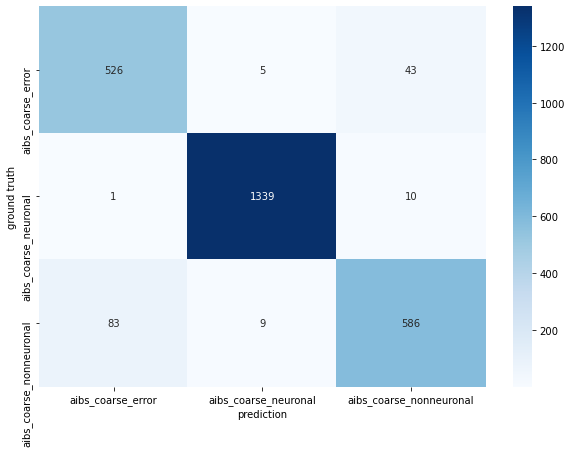

In [351]:
rbf_model, rbf_cm_col  = test_model(rbf_model,all_scaled_col,gt_labels_col, ordered_labels)
plot_cm(rbf_cm_col, cmap='Blues', save_fig=False, filename=test_file)

In [278]:
import pickle
with open('/Users/leilae/aibs/Neural_coding/models/rbf_svm_3class_nucleus_model.pkl','wb') as f:
    pickle.dump(rbf_model,f)

Test Accuracy: 0.9437,Test Precision: 0.9408, Test Recall: 0.9415, Test F1 Score: 0.9408


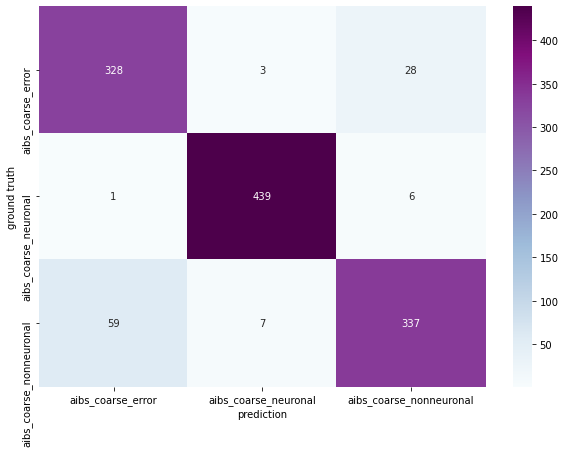

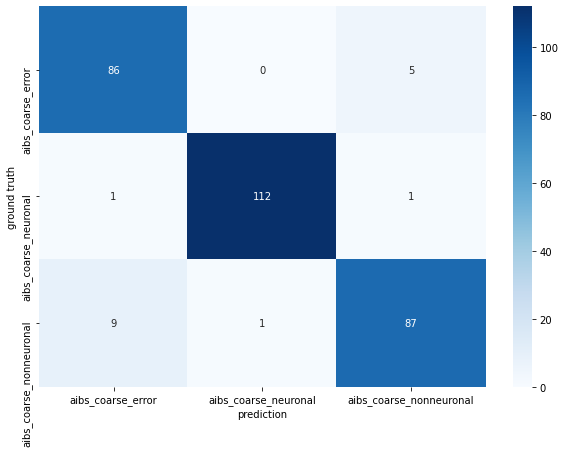

In [289]:
ordered_labels = sorted(balanced[label_col].unique())

params = {'C': 8.683901271916374, 'class_weight': None, 'gamma': 0.08911811010122493, 'kernel': 'rbf'}


svm_model_rbf_2 = SVC(kernel = 'rbf', C = 10,
                    gamma= 0.08920242331473505,
                    class_weight='balanced',
                    decision_function_shape='ovo',
                    probability=True)

rbf_model_2, rbf_cm_2 = train_model(train_dfs,bin_train_labels, svm_model_rbf_2, ordered_labels)
rbf_model_2, test_rbf_cm_2  = test_model(rbf_model_2,val_dfs,bin_val_labels, ordered_labels)

train_file = '/Users/leilae/aibs/Neural_coding/Minnie/column_classifiers/figures/3_class_svm_rbf_train.png'
test_file = '/Users/leilae/aibs/Neural_coding/Minnie/column_classifiers/figures/3_class_svm_rbf_TEST.png'
plot_cm(rbf_cm_2, save_fig=False, filename=train_file)
plot_cm(test_rbf_cm_2, cmap='Blues', save_fig=False, filename=test_file)

### Manual Validation